# **PEDIDOS DE REFEIÇÕES: ANÁLISES INICIAIS E ÁRVORE DE DECISÃO BINÁRIA**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree                                       # Árvore de decisão
from sklearn.model_selection import train_test_split           # Separação de conjuntos de treino e teste
from sklearn.metrics import accuracy_score, confusion_matrix   # Análise de desempenho binária (acurácia, sensibilidade e especificidade)
from sklearn.metrics import roc_auc_score, roc_curve           # Curva ROC
from sklearn.model_selection import cross_val_score            # Validação cruzada
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import GridSearchCV               # Otimização de hiperparâmetros via grid search
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [5]:
dados_refeicoes = pd.read_table("Pedidos_Refeicoes.txt", sep = "\t")

### Visualização da base de dados

In [6]:
display(dados_refeicoes)

,ID_RESPONDENTE,IDADE,GENERO,ESTADO_CIVIL,OCUPACAO_USUAL,RENDA_MENSAL_FAMILIAR,GRAU_EDUCACAO,REFEICAO_MAIS_FREQUENTE,COMPRAS_SAUDAVEIS,RECLAMACAO_ATRASO,AVALIACAO_MEDIA_ANTERIOR,INFLUENCIADO_POR_NOTA
0,1,29,Feminino,Casado,Sem Ocupacao,5300,Graduacao,Almoco,Sim,Sim,4.5,1
1,2,37,Masculino,Casado,Empregado CLT,28100,Pos-Graduacao,Lanches,Sim,Sim,4.5,0
2,3,36,Feminino,Casado,Empregado CLT,14000,Graduacao,Cafe da manha,Nao,Nao,4.2,1
3,4,28,Masculino,Casado,Autonomo,10900,Ensino Fund./Medio,Cafe da manha,Nao,Nao,4.5,0
4,5,31,Feminino,Casado,Estudante,8100,Graduacao,Jantar,Nao,Nao,4.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2739,2740,27,Masculino,Solteiro,Sem Ocupacao,3300,Sem Instrucao,Jantar,Nao,Nao,4.2,1
2740,2741,40,Masculino,Casado,Empregado CLT,3900,Graduacao,Almoco,Nao,Nao,4.6,1
2741,2742,34,Masculino,Casado,Empregado CLT,8700,Sem Instrucao,Almoco,Nao,Nao,4.7,1
2742,2743,48,Feminino,Casado,Empregado CLT,6200,Pos-Graduacao,Lanches,Sim,Nao,4.6,0


### Análise exploratória breve

In [7]:
# Medidas resumo
dados_refeicoes.describe()

,ID_RESPONDENTE,IDADE,RENDA_MENSAL_FAMILIAR,AVALIACAO_MEDIA_ANTERIOR,INFLUENCIADO_POR_NOTA
count,2744.000000,2744.000000,2744.000000,2744.000000,2744.000000
mean,1372.500000,32.576895,8145.007289,4.584220,0.682945
std,792.268894,10.889525,4524.974711,0.186558,0.465414
min,1.000000,18.000000,800.000000,4.000000,0.000000
25%,686.750000,25.000000,4800.000000,4.500000,0.000000
50%,1372.500000,30.000000,7300.000000,4.600000,1.000000
75%,2058.250000,38.000000,10700.000000,4.700000,1.000000
max,2744.000000,86.000000,28100.000000,4.900000,1.000000


### Análise bivariada: features vs. target

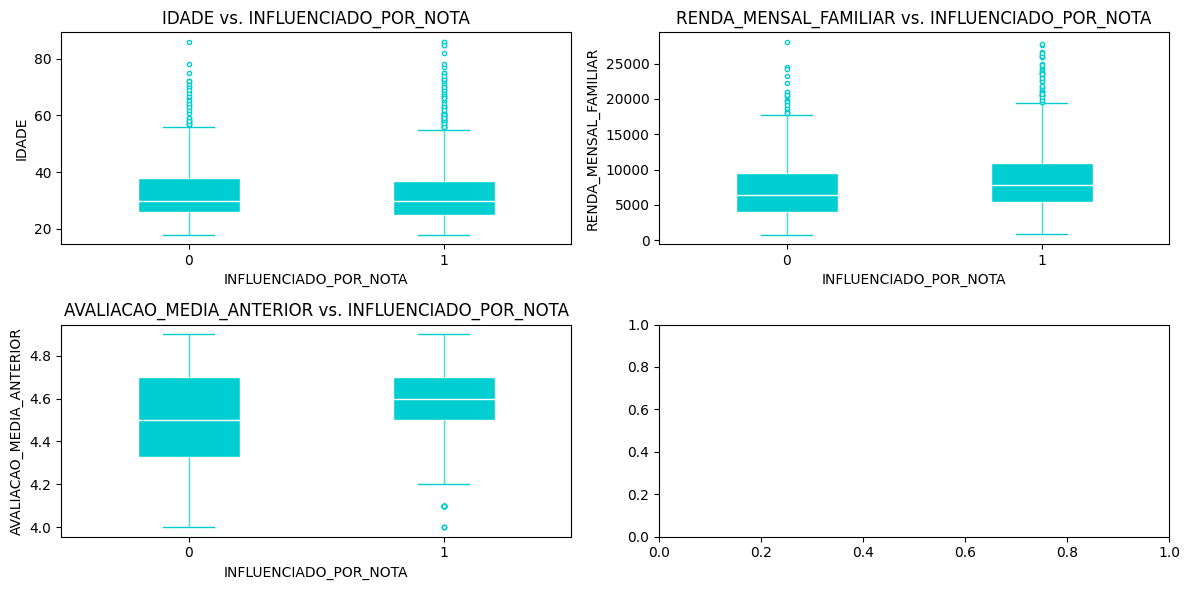

In [10]:
# Gráfico de boxplots: variáveis explicativas quantitativas versus influência por nota
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6))

variaveis = ['IDADE', 'RENDA_MENSAL_FAMILIAR', 'AVALIACAO_MEDIA_ANTERIOR']

for ax, variavel in zip(axes.flat, variaveis):

  sns.boxplot(y = variavel,
              x = 'INFLUENCIADO_POR_NOTA',
              data = dados_refeicoes,
              width = 0.4,
              boxprops = {'facecolor':'darkturquoise', 'edgecolor':'white'},
              whiskerprops = {'color':'turquoise'},
              capprops     = {'color': 'darkturquoise'},
              medianprops  = {'color':'white'},
              flierprops   = {'markerfacecolor': 'white', 'markeredgecolor': 'darkturquoise', 'marker': 'o', 'markersize': 3, 'color': 'turquoise', 'linestyle': 'none'},
              ax = ax)
  ax.set_title(f'{variavel} vs. INFLUENCIADO_POR_NOTA')

plt.tight_layout()
plt.show()

In [11]:
# Tabela de frequências relativas: gênero versus influência por nota
(pd.crosstab(dados_refeicoes['GENERO'], dados_refeicoes['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
GENERO,,
Feminino,31.6,68.4
Masculino,31.8,68.2


In [12]:
# Tabela de frequências relativas: estado civil versus influência por nota
(pd.crosstab(dados_refeicoes['ESTADO_CIVIL'], dados_refeicoes['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
ESTADO_CIVIL,,
Casado,29.5,70.5
Divorciado,31.5,68.5
Solteiro,34.2,65.8
Viúvo,39.2,60.8


In [14]:
# Tabela de frequências relativas: ocupação usual versus influência por nota
(pd.crosstab(dados_refeicoes['OCUPACAO_USUAL'], dados_refeicoes['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
OCUPACAO_USUAL,,
Aposentado,38.3,61.7
Autonomo,30.9,69.1
Empregado CLT,31.4,68.6
Estudante,30.6,69.4
Sem Ocupacao,34.4,65.6


In [19]:
# Tabela de frequências relativas: grau de educação versus influência por nota
(pd.crosstab(dados_refeicoes['GRAU_EDUCACAO'], dados_refeicoes['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
GRAU_EDUCACAO,,
Ensino Fund./Medio,30.9,69.1
Graduacao,31.6,68.4
Pos-Graduacao,31.8,68.2
Sem Instrucao,33.9,66.1


In [16]:
# Tabela de frequências relativas: refeição mais frequente versus influência por nota
(pd.crosstab(dados_refeicoes['REFEICAO_MAIS_FREQUENTE'], dados_refeicoes['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
REFEICAO_MAIS_FREQUENTE,,
Almoco,23.1,76.9
Cafe da manha,31.1,68.9
Jantar,29.3,70.7
Lanches,44.2,55.8


In [17]:
# Tabela de frequências relativas: compras saudáveis versus influência por nota
(pd.crosstab(dados_refeicoes['COMPRAS_SAUDAVEIS'], dados_refeicoes['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
COMPRAS_SAUDAVEIS,,
Nao,34.4,65.6
Sim,19.9,80.1


In [18]:
# Tabela de frequências relativas: reclamação por atraso versus influência por nota
(pd.crosstab(dados_refeicoes['RECLAMACAO_ATRASO'], dados_refeicoes['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
RECLAMACAO_ATRASO,,
Nao,33.6,66.4
Sim,18.9,81.1


### Separação de features e target

In [20]:
X = dados_refeicoes.drop(columns = ['INFLUENCIADO_POR_NOTA', 'ID_RESPONDENTE'])
y = dados_refeicoes['INFLUENCIADO_POR_NOTA']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [23]:
X = pd.get_dummies(X, drop_first = True)

### Modelo 1: árvore de decisão com otimização de hiperparâmetros via validação cruzada, com grid search

In [24]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [2, 3, 5, 10]
}

In [25]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com grid search, com otimização de AUC e k = 10
arvore = tree.DecisionTreeClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(arvore, param_grid, cv = cv, scoring = scoring, refit = 'AUC')
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10],
                         'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
                         'min_samples_leaf': [10, 20, 50, 100]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'balanced_accuracy': 'balanced_accuracy',
                      'recall': 'recall'})

In [26]:
# Melhor configuração de hiperparâmetros identificada
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 100}


In [27]:
# Tabela de desempenho com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(grid_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
51,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",0.779750,0.020312,1,0.683370,0.022962,38,0.892657,0.021850,89
115,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.779392,0.017790,2,0.683370,0.022962,38,0.892657,0.021850,89
98,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.777701,0.020966,3,0.705492,0.017664,1,0.890587,0.011145,95
34,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.777092,0.019080,4,0.705492,0.017664,1,0.890587,0.011145,95
114,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.776472,0.013538,5,0.704074,0.018553,3,0.886484,0.018593,97
...,...,...,...,...,...,...,...,...,...,...
45,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.500000,0.000000,81,0.500000,0.000000,81,1.000000,0.000000,1
44,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.500000,0.000000,81,0.500000,0.000000,81,1.000000,0.000000,1
43,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.500000,0.000000,81,0.500000,0.000000,81,1.000000,0.000000,1
41,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.500000,0.000000,81,0.500000,0.000000,81,1.000000,0.000000,1


In [28]:
# Modelo final a partir da melhor combinação de hiperparâmetros
arvore_1 = grid_search.best_estimator_

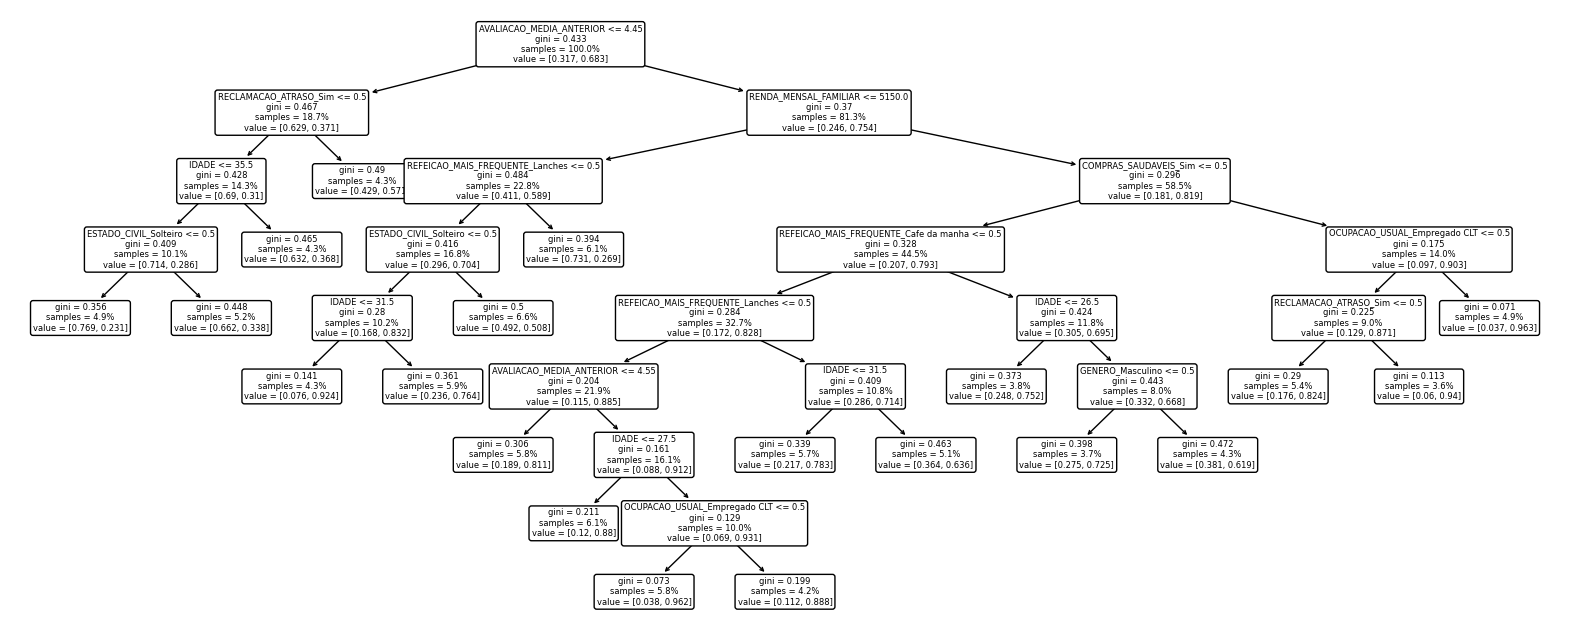

In [29]:
# Visualização da árvore de decisão correspondente ao melhor modelo (em 100% da base de dados)
plt.figure(figsize = (20, 8))
tree.plot_tree(arvore_1,
               feature_names = X.columns,
               fontsize = 6,
               rounded = True,
               proportion = True)
plt.show()

### Modelo 2: árvore de decisão com otimização de hiperparâmetros via validação cruzada, com random search

In [30]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': np.arange(0, 0.11, 0.01),
    'min_samples_leaf': np.arange(10, 101),
    'max_depth': np.arange(2, 11),
}

In [31]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC e k = 10
arvore = tree.DecisionTreeClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(arvore, param_grid, cv = cv, scoring = scoring, refit = 'AUC', n_iter = 100, random_state = 123)
random_search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=123),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_impurity_decrease': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'min_samples_leaf': array([ 10,  11,  12,  13,  14...
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   random_state=123, refit='AUC',
                   scoring={'AUC': 'roc_auc',
                            'balanced_accuracy': 'balanced_accuracy',
                            'recall': 'recall'})

In [32]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'min_samples_leaf': 25, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'criterion': 'entropy'}


In [33]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
36,"{'min_samples_leaf': 25, 'min_impurity_decreas...",0.780338,0.021343,1,0.692240,0.019900,10,0.890467,0.017624,90
59,"{'min_samples_leaf': 41, 'min_impurity_decreas...",0.776524,0.020637,2,0.709603,0.016326,1,0.875175,0.019699,92
65,"{'min_samples_leaf': 31, 'min_impurity_decreas...",0.772799,0.016760,3,0.692178,0.013925,11,0.873918,0.020457,97
23,"{'min_samples_leaf': 30, 'min_impurity_decreas...",0.768926,0.018969,4,0.692367,0.013769,9,0.871853,0.018901,98
78,"{'min_samples_leaf': 45, 'min_impurity_decreas...",0.757045,0.017444,5,0.692421,0.023759,4,0.883129,0.019096,91
...,...,...,...,...,...,...,...,...,...,...
17,"{'min_samples_leaf': 33, 'min_impurity_decreas...",0.500000,0.000000,62,0.500000,0.000000,62,1.000000,0.000000,1
50,"{'min_samples_leaf': 70, 'min_impurity_decreas...",0.500000,0.000000,62,0.500000,0.000000,62,1.000000,0.000000,1
77,"{'min_samples_leaf': 49, 'min_impurity_decreas...",0.500000,0.000000,62,0.500000,0.000000,62,1.000000,0.000000,1
41,"{'min_samples_leaf': 50, 'min_impurity_decreas...",0.500000,0.000000,62,0.500000,0.000000,62,1.000000,0.000000,1


In [34]:
# Modelo final a partir da melhor combinação de hiperparâmetros
arvore_2 = random_search.best_estimator_

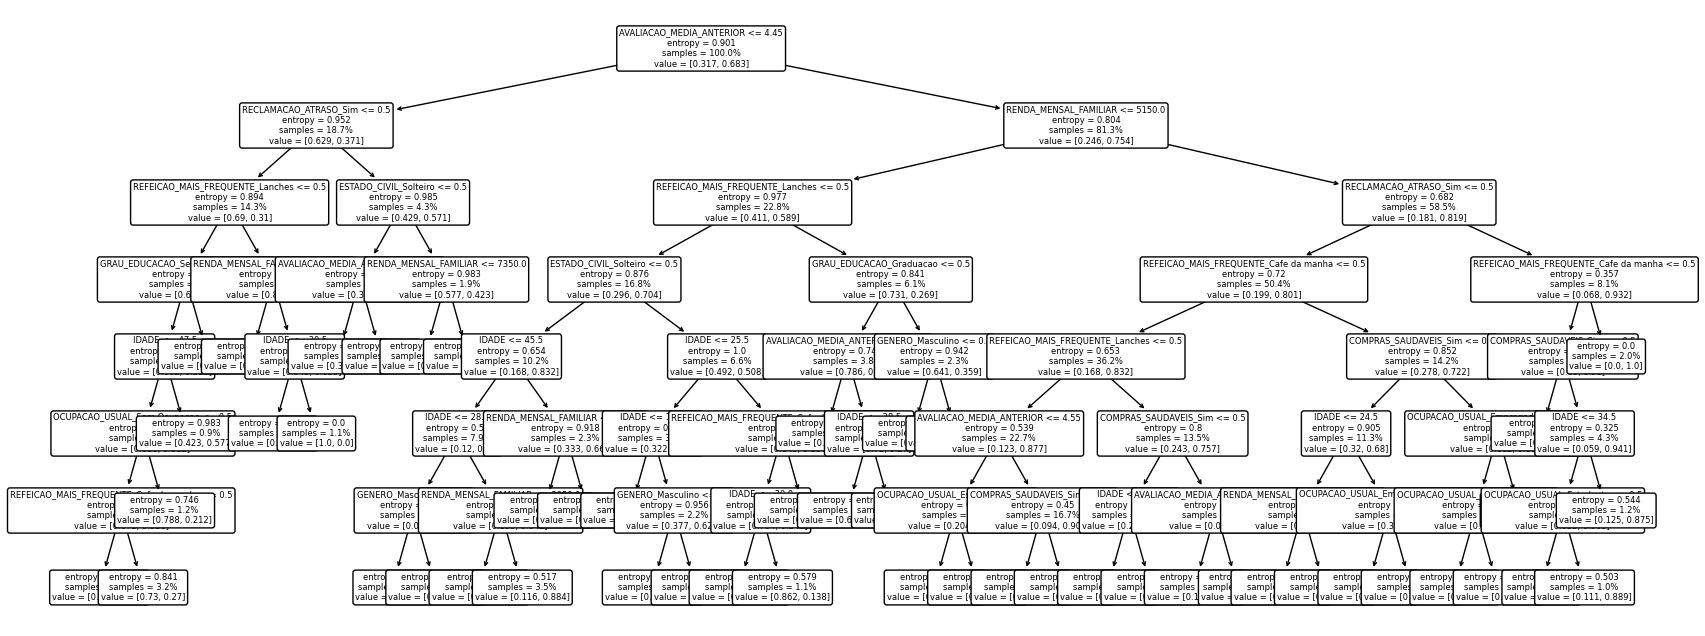

In [35]:
# Visualização da árvore de decisão correspondente ao melhor modelo (em 100% da base de dados)
plt.figure(figsize = (20, 8))
tree.plot_tree(arvore_2,
               feature_names = X.columns,
               fontsize = 6,
               rounded = True,
               proportion = True)
plt.show()

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [36]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [2, 3, 5, 10]
}

In [37]:
# Validação cruzada aninhada com grid search e otimização de AUC, k1 = 3 e k2 = 5
arvore = tree.DecisionTreeClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(arvore, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC')
nested_scores = cross_validate(grid_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [38]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.771 0.785 0.773 0.764 0.774]
Média de AUC: 0.773
D.P. de AUC: 0.007


In [39]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.695 0.72  0.711 0.682 0.704]
Média de Acurácia Balanceada: 0.702
D.P. de Acurácia Balanceada: 0.013


In [40]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.89  0.878 0.891 0.897 0.886]
Média de Sensibilidade: 0.888
D.P. de Sensibilidade: 0.006


### Estimativa de desempenho do modelo 2 em dados totalmente apartados, via validação cruzada aninhada

In [41]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': np.arange(0, 0.11, 0.01),
    'min_samples_leaf': np.arange(10, 101),
    'max_depth': np.arange(2, 11),
}

In [42]:
# Validação cruzada aninhada com random search e otimização de AUC, k1 = 3 e k2 = 5
arvore = tree.DecisionTreeClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(arvore, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 100, random_state = 123)
nested_scores = cross_validate(random_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [43]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.766 0.789 0.77  0.773 0.77 ]
Média de AUC: 0.774
D.P. de AUC: 0.008


In [44]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.678 0.718 0.692 0.699 0.699]
Média de Acurácia Balanceada: 0.697
D.P. de Acurácia Balanceada: 0.013


In [45]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.898 0.862 0.899 0.897 0.87 ]
Média de Sensibilidade: 0.885
D.P. de Sensibilidade: 0.016


### Aplicação do modelo final de árvore de decisão na base de dados



In [46]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = arvore_1.predict_proba(X)[:,1]

In [47]:
# Definição de ponto de corte
ponto_corte = y.astype(int).mean()

In [49]:
# Atribuição da categoria predita
dados_refeicoes['y_pred'] = (y_prob >= ponto_corte).astype(int)

### Importância das features do modelo final

In [50]:
# Cálculo de medida de importância de Gini
importancias = arvore_1.feature_importances_
features = X.columns

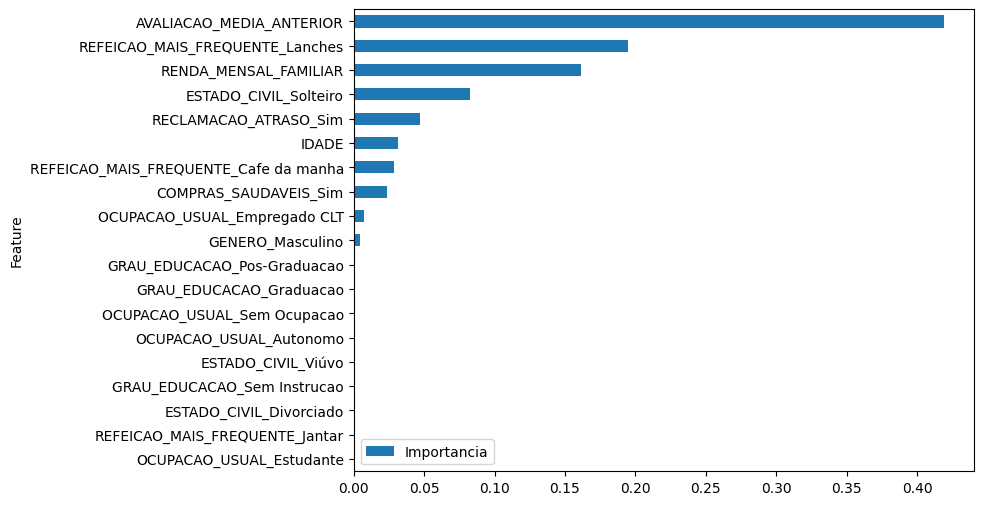

In [51]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [52]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(arvore_1)
valores_shap = explainer(X)

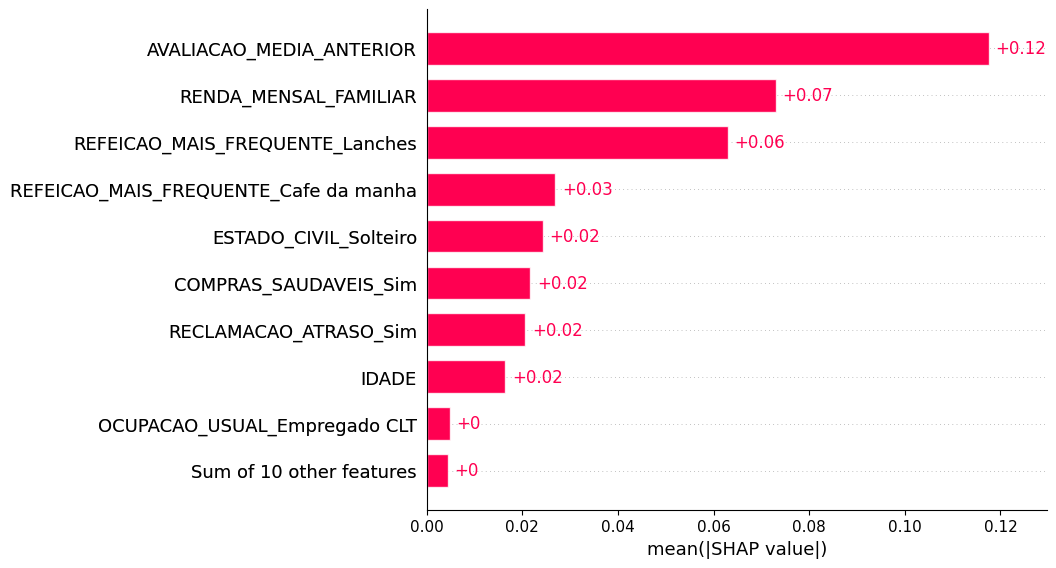

In [53]:
# Gráfico do SHAP absoluto médio por feature
shap.plots.bar(valores_shap[:,:,0])

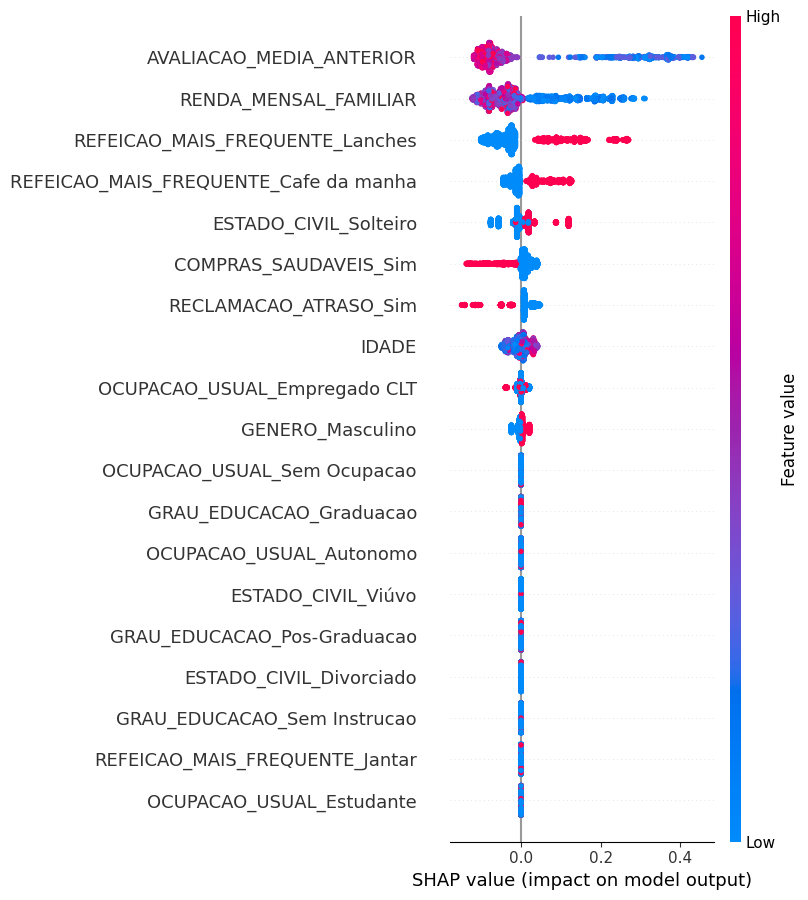

In [54]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
shap.summary_plot(valores_shap[:,:,0])